# Feature Sieve Regression
## Dataset: Facial Beauty SCUT - FBP5500

In [1]:
# importing libraries
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torchvision import transforms, models
import pandas as pd
import os

from torchsummary import summary
from tqdm import tqdm
import matplotlib.patches as mpatches
import seaborn as sns

# importing functions for the models
from scripts.models import *
from scripts.train import *

In [2]:
# initializing the seeds
SEED = 3407
# setting random seed
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
# torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#setting device
device = torch.device("cuda" if torch.cuda.is_available() else "CPU")
torch.cuda.set_device(1)
print(device)

cuda


## Data

In [3]:
DATA_PATH = "./FacialBeautyData/scut_fbp5500-cmprsd.npz"
data = np.load(DATA_PATH)
inputs, targets = data['X'], data['y']
inputs = inputs.reshape((-1, inputs.shape[-1], inputs.shape[1],inputs.shape[2]))
print(f"Data shape: {inputs.shape}")

Data shape: (5500, 3, 350, 350)


In [4]:
TRAIN_PTS, VALID_PTS, TEST_PTS = int(inputs.shape[0] * 0.6), int(inputs.shape[0] * 0.2), int(inputs.shape[0] * 0.2)

train_data, train_targets = inputs[:TRAIN_PTS].astype(np.float32), targets[:TRAIN_PTS].astype(np.float32)
valid_data, valid_targets = inputs[TRAIN_PTS: TRAIN_PTS + VALID_PTS].astype(np.float32), targets[TRAIN_PTS: TRAIN_PTS + VALID_PTS].astype(np.float32)
test_data, test_targets = inputs[TRAIN_PTS + VALID_PTS: ].astype(np.float32), targets[TRAIN_PTS + VALID_PTS: ].astype(np.float32)

print(f"# of Training points: {train_data.shape[0]}")
print(f"# of Valid points: {valid_data.shape[0]}")
print(f"# of Test points: {test_data.shape[0]}")

# of Training points: 3300
# of Valid points: 1100
# of Test points: 1100


In [5]:
# getting the ethinicity and gender
with open("./FacialBeautyData/labels.txt") as f:
    lines = f.readlines()
    lines = [i.rstrip().split() for i in lines]
    # Gender: M --> 1 F--> 0
    # Ethinicity: A --> 1 C --> 0
    gender = [1 if i[0][1] == "M" else 0 for i in lines ]
    ethinicity = [1 if i[0][0]== "A" else 0  for i in lines]
    labels = [i[0][:-4] for i in lines]

gender = np.array(gender)
ethinicity = np.array(ethinicity)
labels = np.array(labels)

# correlation Calculation
data_df = pd.DataFrame(np.array([labels, gender, ethinicity, targets]).T, columns = ['Labels', "Gender", 'Ethinicity', 'Targets'])
data_df = data_df.set_index("Labels").astype(float)
data_df = data_df.reset_index()
data_df.head()

,Labels,Gender,Ethinicity,Targets
0,CF437,0.0,0.0,2.883333
1,AM1384,1.0,1.0,2.466667
2,AM1234,1.0,1.0,2.150000
3,AM1774,1.0,1.0,3.750000
4,CF215,0.0,0.0,3.033333


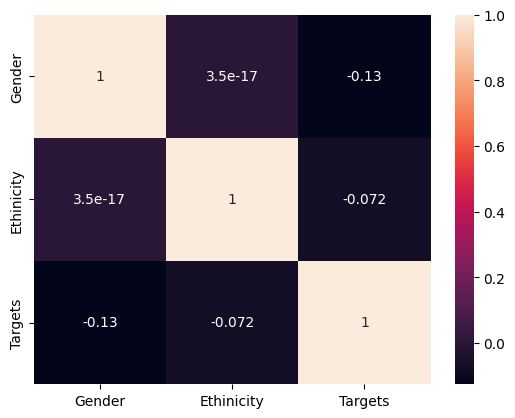

In [6]:
# correaltion between variables
corr = data_df.corr(numeric_only = True)
sns.heatmap(corr, annot = True)
plt.show()

## Dataloaders and Dataset

In [7]:
BATCH_SIZE = 64

class FBPDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
    def __getitem__(self, idx):
        x, y = self.inputs[idx], self.targets[idx]
        return x,y
    def __len__(self):
        return self.inputs.shape[0]

train_dataset = FBPDataset(train_data, train_targets)
valid_dataset = FBPDataset(valid_data, valid_targets)
test_dataset =  FBPDataset(test_data, test_targets)

train_dataloader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
valid_dataloader = DataLoader(dataset = valid_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = True)

## Groups

In [8]:
test_df = data_df[TRAIN_PTS + VALID_PTS: ]
male_df = test_df[test_df['Gender'] == 1]
female_df = test_df[test_df['Gender'] == 0]

male_b_df = male_df[male_df['Targets']> 2.5]
male_u_df = male_df[male_df['Targets']<= 2.5]

female_b_df = female_df[female_df['Targets'] > 2.5]
female_u_df = female_df[female_df['Targets'] <= 2.5]

male_b_df.head()

,Labels,Gender,Ethinicity,Targets
4400,AM1421,1.0,1.0,2.850000
4403,CM385,1.0,0.0,2.866667
4404,CM4,1.0,0.0,4.316667
4406,AM927,1.0,1.0,2.716667
4407,AM266,1.0,1.0,2.883333


In [9]:
male_b_data, male_b_targets = inputs[male_b_df.index.to_list()].astype(np.float32), targets[male_b_df.index.to_list()].astype(np.float32)
male_u_data, male_u_targets = inputs[male_u_df.index.to_list()].astype(np.float32), targets[male_u_df.index.to_list()].astype(np.float32)
female_u_data, female_u_targets = inputs[female_u_df.index.to_list()].astype(np.float32), targets[female_u_df.index.to_list()].astype(np.float32)
female_b_data, female_b_targets = inputs[female_b_df.index.to_list()].astype(np.float32), targets[female_b_df.index.to_list()].astype(np.float32)

print(f"# of datapoints of male above 2.5: {male_b_data.shape[0]}")
print(f"# of datapoints of male below 2.5: {male_u_data.shape[0]}")
print(f"# of datapoints of female above 2.5: {female_b_data.shape[0]}")
print(f"# of datapoins of female below 2.5: {female_u_data.shape[0]}")

# of datapoints of male above 2.5: 370
# of datapoints of male below 2.5: 151
# of datapoints of female above 2.5: 454
# of datapoins of female below 2.5: 125


In [10]:
male_b_dataset = FBPDataset(male_b_data, male_b_targets)
male_u_dataset = FBPDataset(male_u_data, male_u_targets)
female_b_dataset = FBPDataset(female_b_data, female_b_targets)
female_u_dataset = FBPDataset(female_u_data, female_u_targets)

male_b_dataloader = DataLoader(male_b_dataset, batch_size=BATCH_SIZE, shuffle  = True)
male_u_dataloader = DataLoader(male_u_dataset, batch_size=BATCH_SIZE, shuffle  = True)
female_b_dataloader = DataLoader(female_b_dataset, batch_size=BATCH_SIZE, shuffle  = True)
female_u_dataloader = DataLoader(female_u_dataset, batch_size=BATCH_SIZE, shuffle  = True)

group_dataloaders = {'m b': male_b_dataloader, "m u": male_u_dataloader, 'f b': female_b_dataloader, 'f u':female_u_dataloader}

In [11]:
## eval functions
x, _ = next(iter(train_dataloader))
def group_eval_cnn(model, group_dataloaders):
    sum_ = 0
    count = 0
    groups = {}
    
    for i in group_dataloaders.keys():
        if group_dataloaders[i] != None:
            test_loss = eval_model(model, group_dataloaders[i])
            count += 1
        else:
            test_loss = 0
        
        sum_ += test_loss
        groups[i] = test_loss
        
    print(f"Group test Loss: {sum_ / count}")
    return (sum_ /count), groups

def group_eval_fs(model, group_dataloaders):
    sum_ = 0
    count = 0
    groups = {}
    
    for i in group_dataloaders.keys():
        if group_dataloaders[i] != None:
            test_loss = eval_FSModel(model, group_dataloaders[i])
            count += 1
        else:
            test_loss = 0
            
        sum_ += test_loss
        groups[i] = test_loss
        
    print(f"Group test Loss: {sum_ / count}")
    return (sum_ / count), groups

## 1) Resnet34 Results

In [13]:
# hyperparameter tuning
lrs = [1e-5, 5e-4, 1e-4, 5e-3,  1e-3, 1e-2]
wds = [1e-5, 5e-4, 1e-4, 5e-3, 1e-3, 5e-2]

test_losses = np.zeros((len(lrs), len(wds)))
grp_test_losses = np.zeros((len(lrs), len(wds)))

for i in range(len(lrs)):
    for j in range(len(wds)):
        print(f"[{i *len(wds) + j +1}/{len(lrs) * len(wds)}] Lr: {lrs[i]} WD:{wds[j]}")
        model = Resnet34(1).to(device)
        model, train_loss, val_loss = train(model, train_dataloader, valid_dataloader, epochs = 2, verbose = False, lr = lrs[i], weight_decay = wds[j])
        test_loss = eval_model(model, test_dataloader)
        print(f"Test Loss: {test_loss}")
        group_tst_loss = group_eval_cnn(model, group_dataloaders)

        test_losses[i,j] = test_loss
        grp_test_losses[i,j] = group_tst_loss[0]

best_lr, best_wd = np.unravel_index(np.argmin(test_losses), test_losses.shape)
best_grp_lr, best_grp_wd = np.unravel_index(np.argmin(grp_test_losses), grp_test_losses.shape)

print(f"Best LR: {lrs[best_lr]} Best WD: {wds[best_wd]}")
print(f"Group wise hyperparameters: \n Best LR: {lrs[best_grp_lr]} Best WD: {wds[best_grp_wd]}")

[1/36] Lr: 1e-05 WD:1e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:55<00:00, 27.99s/it]


Test Loss: 1.216904878616333
Group test Loss: 0.9784858673810959
[2/36] Lr: 1e-05 WD:0.0005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:58<00:00, 29.15s/it]


Test Loss: 0.6920133829116821
Group test Loss: 0.6228132620453835
[3/36] Lr: 1e-05 WD:0.0001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.82s/it]


Test Loss: 1.5198590755462646
Group test Loss: 1.217541977763176
[4/36] Lr: 1e-05 WD:0.005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.96s/it]


Test Loss: 0.5562348365783691
Group test Loss: 0.547787070274353
[5/36] Lr: 1e-05 WD:0.001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.77s/it]


Test Loss: 0.7342512607574463
Group test Loss: 0.6755091845989227
[6/36] Lr: 1e-05 WD:0.05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.95s/it]


Test Loss: 0.5580974817276001
Group test Loss: 0.5446296371519566
[7/36] Lr: 0.0005 WD:1e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.78s/it]


Test Loss: 0.25069165229797363
Group test Loss: 0.6524827070534229
[8/36] Lr: 0.0005 WD:0.0005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.95s/it]


Test Loss: 0.23120303452014923
Group test Loss: 0.5251919142901897
[9/36] Lr: 0.0005 WD:0.0001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.85s/it]


Test Loss: 0.2703036069869995
Group test Loss: 0.47004541009664536
[10/36] Lr: 0.0005 WD:0.005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.91s/it]


Test Loss: 0.27691981196403503
Group test Loss: 0.4503432810306549
[11/36] Lr: 0.0005 WD:0.001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:58<00:00, 29.03s/it]


Test Loss: 0.2348433881998062
Group test Loss: 0.4752932898700237
[12/36] Lr: 0.0005 WD:0.05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.77s/it]


Test Loss: 0.3293466866016388
Group test Loss: 0.7554496750235558
[13/36] Lr: 0.0001 WD:1e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:58<00:00, 29.07s/it]


Test Loss: 0.24316738545894623
Group test Loss: 0.5341886319220066
[14/36] Lr: 0.0001 WD:0.0005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.77s/it]


Test Loss: 0.23106171190738678
Group test Loss: 0.505870059132576
[15/36] Lr: 0.0001 WD:0.0001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.78s/it]


Test Loss: 0.23540474474430084
Group test Loss: 0.5299705490469933
[16/36] Lr: 0.0001 WD:0.005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.92s/it]


Test Loss: 0.24892570078372955
Group test Loss: 0.5000911951065063
[17/36] Lr: 0.0001 WD:0.001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.76s/it]


Test Loss: 0.25865206122398376
Group test Loss: 0.49069901555776596
[18/36] Lr: 0.0001 WD:0.05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.71s/it]


Test Loss: 0.24916629493236542
Group test Loss: 0.5362136736512184
[19/36] Lr: 0.005 WD:1e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.84s/it]


Test Loss: 0.43012362718582153
Group test Loss: 0.7197104692459106
[20/36] Lr: 0.005 WD:0.0005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.75s/it]


Test Loss: 0.37332502007484436
Group test Loss: 0.5304447561502457
[21/36] Lr: 0.005 WD:0.0001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.80s/it]


Test Loss: 0.3998757004737854
Group test Loss: 0.7619192227721214
[22/36] Lr: 0.005 WD:0.005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.85s/it]


Test Loss: 0.3610629141330719
Group test Loss: 0.4883040264248848
[23/36] Lr: 0.005 WD:0.001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.81s/it]


Test Loss: 0.3300205171108246
Group test Loss: 0.5608864575624466
[24/36] Lr: 0.005 WD:0.05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.75s/it]


Test Loss: 0.5312486290931702
Group test Loss: 0.7215965539216995
[25/36] Lr: 0.001 WD:1e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.82s/it]


Test Loss: 0.298376202583313
Group test Loss: 0.5763357095420361
[26/36] Lr: 0.001 WD:0.0005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.82s/it]


Test Loss: 0.2699374258518219
Group test Loss: 0.5833238884806633
[27/36] Lr: 0.001 WD:0.0001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.83s/it]


Test Loss: 0.27992528676986694
Group test Loss: 0.5290715172886848
[28/36] Lr: 0.001 WD:0.005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.71s/it]


Test Loss: 0.30256929993629456
Group test Loss: 0.6889642737805843
[29/36] Lr: 0.001 WD:0.001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.79s/it]


Test Loss: 0.2738269865512848
Group test Loss: 0.5337720438838005
[30/36] Lr: 0.001 WD:0.05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.83s/it]


Test Loss: 0.3596853017807007
Group test Loss: 0.4689418897032738
[31/36] Lr: 0.01 WD:1e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.66s/it]


Test Loss: 0.5081234574317932
Group test Loss: 0.6735161766409874
[32/36] Lr: 0.01 WD:0.0005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.64s/it]


Test Loss: 0.7803026437759399
Group test Loss: 0.7342273369431496
[33/36] Lr: 0.01 WD:0.0001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.74s/it]


Test Loss: 0.44170981645584106
Group test Loss: 0.7060377970337868
[34/36] Lr: 0.01 WD:0.005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.69s/it]


Test Loss: 0.4953238070011139
Group test Loss: 0.9011694118380547
[35/36] Lr: 0.01 WD:0.001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.71s/it]


Test Loss: 0.4267537593841553
Group test Loss: 0.5309672132134438
[36/36] Lr: 0.01 WD:0.05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:57<00:00, 28.60s/it]


Test Loss: 0.5174354910850525
Group test Loss: 0.5293707847595215
Best LR: 0.0001 Best WD: 0.0005
Group wise hyperparameters: 
 Best LR: 0.0005 Best WD: 0.005


In [12]:
lrs = [1e-5, 5e-4, 1e-4, 5e-3,  1e-3, 1e-2]
wds = [1e-5, 5e-4, 1e-4, 5e-3, 1e-3, 5e-2]
best_grp_lr, best_grp_wd = lrs.index(0.0005), wds.index(0.005)

model = Resnet34(1).to(device)
model, train_loss, val_loss = train(model, train_dataloader, valid_dataloader, epochs = 5, verbose = False, lr = lrs[best_grp_lr], weight_decay = wds[best_grp_wd])
test_loss_cnn = eval_model(model, test_dataloader)
print(f"Test Loss: {test_loss_cnn}")
group_tst_loss_cnn, groups_cnn = group_eval_cnn(model, group_dataloaders)

  0%|                                                                      | 0/5 [00:00<?, ?it/s]/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████████████████████████████████████████████████████████| 5/5 [02:25<00:00, 29.08s/it]


Test Loss: 0.2749251127243042


/scratch/storage0/be20b032/miniconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Group test Loss: 0.4634981155395508


## 2) Margin forgetting loss

In [16]:
# hyperparameter tuning
# Hyperparameter Tuning
margins = [1e-5, 1e-4, 1e-3, 1e-3, 1e-1, 1e+1, 2e+1]
forget_lrs = [5e-4, 1e-4, 5e-3, 1e-3, 5e-2, 1e-2]
forget_iters = [2, 5]

test_losses = np.zeros((len(margins), len(forget_lrs), len(forget_iters)))
grp_test_losses = np.zeros((len(margins), len(forget_lrs), len(forget_iters)))

for i in range(len(margins)):
    for j in range(len(forget_lrs)):
        for k in range(len(forget_iters)):
            print(f"[{i*(len(forget_lrs) * len(forget_iters)) + j*(len(forget_iters)) + k + 1} / {len(margins) * len(forget_lrs)* len(forget_iters)}] Margin {margins[i]} Forget Lr: {forget_lrs[j]} Forget Iters: {forget_iters[k]}")
            model = SiFer_margin(x.shape, 1, aux_kernels = [128, 64], layers = [5, 4]).to(device)
            model, train_loss, val_loss,_, _ = train_fs_mar(model, train_dataloader, valid_dataloader, margin = margins[i], forget_iters = forget_iters[k], lrs = [5e-4, 5e-4, forget_lrs[j]], epochs = 2, verbose = False)
            test_loss = eval_FSModel(model, test_dataloader)
            print(f"Test Loss: {test_loss}")
            grp_loss = group_eval_fs(model, group_dataloaders)

            test_losses[i,j,k] = test_loss
            grp_test_losses[i,j,k] = grp_loss[0]

best_margin, best_forget_lr, best_forget_iter = np.unravel_index(np.argmin(test_losses), test_losses.shape)
best_grp_margin, best_grp_forget_lr, best_grp_forget_iter = np.unravel_index(np.argmin(grp_test_losses), grp_test_losses.shape)

print(f"Best Margin : {margins[best_margin]} Best Forget LR: {forget_lrs[best_forget_lr]} Best Forget Iter: {forget_iters[best_forget_iter]}")
print(f"Group hyperparameters: \n Best margin: {margins[best_grp_margin]} Best Forget Lr: {forget_lrs[best_grp_forget_lr]} Best Forget Iter: {forget_iters[best_grp_forget_iter]}")

[1 / 84] Margin 1e-05 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.15s/it]


Test Loss: 0.2465786188840866
Group test Loss: 0.30692240968346596
[2 / 84] Margin 1e-05 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.05s/it]


Test Loss: 0.23083455860614777
Group test Loss: 0.2876342497766018
[3 / 84] Margin 1e-05 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.26s/it]


Test Loss: 0.26835447549819946
Group test Loss: 0.24493765085935593
[4 / 84] Margin 1e-05 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.83s/it]


Test Loss: 0.28784608840942383
Group test Loss: 0.39716680347919464
[5 / 84] Margin 1e-05 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.22s/it]


Test Loss: 0.3158286511898041
Group test Loss: 0.4184190407395363
[6 / 84] Margin 1e-05 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.68s/it]


Test Loss: 0.2261454164981842
Group test Loss: 0.2379336953163147
[7 / 84] Margin 1e-05 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.36s/it]


Test Loss: 0.25937631726264954
Group test Loss: 0.2590816281735897
[8 / 84] Margin 1e-05 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.72s/it]


Test Loss: 0.23264563083648682
Group test Loss: 0.2623366303741932
[9 / 84] Margin 1e-05 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.07s/it]


Test Loss: 0.21495786309242249
Group test Loss: 0.2439284659922123
[10 / 84] Margin 1e-05 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.97s/it]


Test Loss: 0.2453329712152481
Group test Loss: 0.286990150809288
[11 / 84] Margin 1e-05 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.24s/it]


Test Loss: 0.2790696322917938
Group test Loss: 0.26630212366580963
[12 / 84] Margin 1e-05 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.93s/it]


Test Loss: 0.24271553754806519
Group test Loss: 0.31557178869843483
[13 / 84] Margin 0.0001 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.17s/it]


Test Loss: 0.24230554699897766
Group test Loss: 0.24342205375432968
[14 / 84] Margin 0.0001 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.86s/it]


Test Loss: 0.26899829506874084
Group test Loss: 0.30473947897553444
[15 / 84] Margin 0.0001 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.09s/it]


Test Loss: 0.356478214263916
Group test Loss: 0.5083541497588158
[16 / 84] Margin 0.0001 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.96s/it]


Test Loss: 0.268239289522171
Group test Loss: 0.2497572898864746
[17 / 84] Margin 0.0001 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:11<00:00, 65.97s/it]


Test Loss: 0.2206176072359085
Group test Loss: 0.24020569398999214
[18 / 84] Margin 0.0001 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.98s/it]


Test Loss: 0.226377934217453
Group test Loss: 0.225646760314703
[19 / 84] Margin 0.0001 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.38s/it]


Test Loss: 0.21279533207416534
Group test Loss: 0.2507828325033188
[20 / 84] Margin 0.0001 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.86s/it]


Test Loss: 0.2308640480041504
Group test Loss: 0.2683987393975258
[21 / 84] Margin 0.0001 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.07s/it]


Test Loss: 0.2346246838569641
Group test Loss: 0.286398246884346
[22 / 84] Margin 0.0001 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.98s/it]


Test Loss: 0.3096280097961426
Group test Loss: 0.42391616106033325
[23 / 84] Margin 0.0001 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.21s/it]


Test Loss: 0.23157998919487
Group test Loss: 0.27459432929754257
[24 / 84] Margin 0.0001 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.84s/it]


Test Loss: 0.32868140935897827
Group test Loss: 0.4225984625518322
[25 / 84] Margin 0.001 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.28s/it]


Test Loss: 0.25502780079841614
Group test Loss: 0.288749061524868
[26 / 84] Margin 0.001 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.86s/it]


Test Loss: 0.29122111201286316
Group test Loss: 0.2506901416927576
[27 / 84] Margin 0.001 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.23s/it]


Test Loss: 0.23280978202819824
Group test Loss: 0.28003961592912674
[28 / 84] Margin 0.001 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.87s/it]


Test Loss: 0.2274717092514038
Group test Loss: 0.2926745004951954
[29 / 84] Margin 0.001 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.11s/it]


Test Loss: 0.24649924039840698
Group test Loss: 0.2841745540499687
[30 / 84] Margin 0.001 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.00s/it]


Test Loss: 0.24841441214084625
Group test Loss: 0.2612149156630039
[31 / 84] Margin 0.001 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:11<00:00, 65.99s/it]


Test Loss: 0.24572116136550903
Group test Loss: 0.32111118733882904
[32 / 84] Margin 0.001 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.75s/it]


Test Loss: 0.33315005898475647
Group test Loss: 0.2872562874108553
[33 / 84] Margin 0.001 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.22s/it]


Test Loss: 0.2403097301721573
Group test Loss: 0.25834424421191216
[34 / 84] Margin 0.001 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.92s/it]


Test Loss: 0.2749502658843994
Group test Loss: 0.2496917974203825
[35 / 84] Margin 0.001 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.03s/it]


Test Loss: 0.22457511723041534
Group test Loss: 0.250253651291132
[36 / 84] Margin 0.001 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.78s/it]


Test Loss: 0.2617581784725189
Group test Loss: 0.36407439038157463
[37 / 84] Margin 0.001 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.15s/it]


Test Loss: 0.2328052818775177
Group test Loss: 0.2985120713710785
[38 / 84] Margin 0.001 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.86s/it]


Test Loss: 0.22880202531814575
Group test Loss: 0.3008626811206341
[39 / 84] Margin 0.001 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.61s/it]


Test Loss: 0.24585571885108948
Group test Loss: 0.2873416543006897
[40 / 84] Margin 0.001 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.82s/it]


Test Loss: 0.21077048778533936
Group test Loss: 0.24319616705179214
[41 / 84] Margin 0.001 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.16s/it]


Test Loss: 0.24270662665367126
Group test Loss: 0.27083738148212433
[42 / 84] Margin 0.001 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.95s/it]


Test Loss: 0.2795677185058594
Group test Loss: 0.3840594217181206
[43 / 84] Margin 0.001 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.13s/it]


Test Loss: 0.23083487153053284
Group test Loss: 0.28429165482521057
[44 / 84] Margin 0.001 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.96s/it]


Test Loss: 0.22009599208831787
Group test Loss: 0.2763003073632717
[45 / 84] Margin 0.001 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.30s/it]


Test Loss: 0.23352769017219543
Group test Loss: 0.25520673766732216
[46 / 84] Margin 0.001 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.11s/it]


Test Loss: 0.30789148807525635
Group test Loss: 0.27087128162384033
[47 / 84] Margin 0.001 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.56s/it]


Test Loss: 0.23549427092075348
Group test Loss: 0.242048017680645
[48 / 84] Margin 0.001 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.09s/it]


Test Loss: 0.2954491972923279
Group test Loss: 0.26598672568798065
[49 / 84] Margin 0.1 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.19s/it]


Test Loss: 0.2565329968929291
Group test Loss: 0.30538394674658775
[50 / 84] Margin 0.1 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.15s/it]


Test Loss: 0.24064494669437408
Group test Loss: 0.2755035385489464
[51 / 84] Margin 0.1 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.03s/it]


Test Loss: 0.23462077975273132
Group test Loss: 0.30099721997976303
[52 / 84] Margin 0.1 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.77s/it]


Test Loss: 0.24257934093475342
Group test Loss: 0.2412269189953804
[53 / 84] Margin 0.1 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.15s/it]


Test Loss: 0.24325355887413025
Group test Loss: 0.2640226520597935
[54 / 84] Margin 0.1 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.95s/it]


Test Loss: 0.22354039549827576
Group test Loss: 0.287371713668108
[55 / 84] Margin 0.1 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.48s/it]


Test Loss: 0.23221741616725922
Group test Loss: 0.2797706238925457
[56 / 84] Margin 0.1 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.80s/it]


Test Loss: 0.2418578565120697
Group test Loss: 0.2571696266531944
[57 / 84] Margin 0.1 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.34s/it]


Test Loss: 0.23738932609558105
Group test Loss: 0.27910761907696724
[58 / 84] Margin 0.1 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.29s/it]


Test Loss: 0.25283244252204895
Group test Loss: 0.2512630484998226
[59 / 84] Margin 0.1 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.23s/it]


Test Loss: 0.26016750931739807
Group test Loss: 0.30369096994400024
[60 / 84] Margin 0.1 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.27s/it]


Test Loss: 0.2633897662162781
Group test Loss: 0.3436257652938366
[61 / 84] Margin 10.0 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.43s/it]


Test Loss: 0.2308727502822876
Group test Loss: 0.2714138515293598
[62 / 84] Margin 10.0 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.03s/it]


Test Loss: 0.31211429834365845
Group test Loss: 0.2592105772346258
[63 / 84] Margin 10.0 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.28s/it]


Test Loss: 0.21486493945121765
Group test Loss: 0.22977405413985252
[64 / 84] Margin 10.0 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.20s/it]


Test Loss: 0.2615627944469452
Group test Loss: 0.3304959014058113
[65 / 84] Margin 10.0 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.50s/it]


Test Loss: 0.36513620615005493
Group test Loss: 0.31945667788386345
[66 / 84] Margin 10.0 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.11s/it]


Test Loss: 0.2792900800704956
Group test Loss: 0.33797817677259445
[67 / 84] Margin 10.0 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.23s/it]


Test Loss: 0.3956539034843445
Group test Loss: 0.32136089727282524
[68 / 84] Margin 10.0 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.92s/it]


Test Loss: 0.33962562680244446
Group test Loss: 0.3125480115413666
[69 / 84] Margin 10.0 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.36s/it]


Test Loss: 0.4993304908275604
Group test Loss: 0.5972314551472664
[70 / 84] Margin 10.0 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.77s/it]


Test Loss: 0.5547906160354614
Group test Loss: 0.7967506647109985
[71 / 84] Margin 10.0 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.43s/it]


Test Loss: 0.3210463523864746
Group test Loss: 0.3399479389190674
[72 / 84] Margin 10.0 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.87s/it]


Test Loss: 0.32544657588005066
Group test Loss: 0.34102971106767654
[73 / 84] Margin 20.0 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.39s/it]


Test Loss: 0.33826905488967896
Group test Loss: 0.35605716705322266
[74 / 84] Margin 20.0 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.03s/it]


Test Loss: 0.2243313491344452
Group test Loss: 0.27096210420131683
[75 / 84] Margin 20.0 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.50s/it]


Test Loss: 0.2353014051914215
Group test Loss: 0.23926522955298424
[76 / 84] Margin 20.0 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.09s/it]


Test Loss: 0.223393514752388
Group test Loss: 0.2551957182586193
[77 / 84] Margin 20.0 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.21s/it]


Test Loss: 0.40991833806037903
Group test Loss: 0.5593563467264175
[78 / 84] Margin 20.0 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.93s/it]


Test Loss: 0.2743105888366699
Group test Loss: 0.27154694870114326
[79 / 84] Margin 20.0 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.31s/it]


Test Loss: 0.2648026645183563
Group test Loss: 0.315675962716341
[80 / 84] Margin 20.0 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.88s/it]


Test Loss: 0.24811837077140808
Group test Loss: 0.27932310476899147
[81 / 84] Margin 20.0 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.14s/it]


Test Loss: 0.38374823331832886
Group test Loss: 0.460624024271965
[82 / 84] Margin 20.0 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.92s/it]


Test Loss: 0.4504826068878174
Group test Loss: 0.3884863071143627
[83 / 84] Margin 20.0 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.26s/it]


Test Loss: 0.37743356823921204
Group test Loss: 0.4742295444011688
[84 / 84] Margin 20.0 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.96s/it]


Test Loss: 0.38249319791793823
Group test Loss: 0.5175871104001999
Best Margin : 0.001 Best Forget LR: 0.0001 Best Forget Iter: 5
Group hyperparameters: 
 Best margin: 0.0001 Best Forget Lr: 0.005 Best Forget Iter: 5


In [24]:
margins = [1e-5, 1e-4, 1e-3, 1e-3, 1e-1, 1e+1, 2e+1]
forget_lrs = [5e-4, 1e-4, 5e-3, 1e-3, 5e-2, 1e-2]
forget_iters = [2, 5]

best_grp_margin, best_grp_forget_lr, best_grp_forget_iter = margins.index(0.0001), forget_lrs.index(0.005), forget_iters.index(5)

sifer_margin = SiFer_margin(x.shape, 1, aux_kernels = [128, 64], layers = [5, 4]).to(device)
sifer_margin, train_loss, val_loss,_, _ = train_fs_mar(sifer_margin, train_dataloader, valid_dataloader, margin = margins[best_grp_margin], forget_iters = forget_iters[best_grp_forget_iter], lrs = [5e-4, 5e-4, forget_lrs[best_grp_forget_lr]], epochs = 5, verbose = False)
test_loss_mar = eval_FSModel(sifer_margin, test_dataloader)
print(f"Test Loss: {test_loss_mar}")
group_tst_loss_mar, groups_fs_mar = group_eval_fs(sifer_margin, group_dataloaders)

100%|██████████████████████████████████████████████████████████████| 5/5 [04:59<00:00, 59.80s/it]


Test Loss: 0.2444404810667038
Group test Loss: 0.2557152546942234


## 3) Cross Entropy Forgetting loss

In [18]:
num_bins = [2, 10, 25, 30, 50, 75, 90, 100]
forget_lrs = [5e-4, 1e-4, 5e-3, 1e-3, 5e-2, 1e-2]
forget_iters = [2, 5]

test_losses = np.zeros((len(num_bins), len(forget_lrs), len(forget_iters)))
grp_test_losses = np.zeros((len(num_bins), len(forget_lrs), len(forget_iters)))

for i in range(len(num_bins)):
    for j in range(len(forget_lrs)):
        for k in range(len(forget_iters)):
            print(f"{i*(len(forget_lrs) * len(forget_iters)) + j*(len(forget_iters)) + k + 1}/{len(num_bins) * len(forget_lrs)* len(forget_iters)}) Num Bins {num_bins[i]} Forget Lr: {forget_lrs[j]} Forget Iters: {forget_iters[k]}")
            model = SiFer_ce(x.shape, 1, num_bins = num_bins[i]).to(device)
            model, train_loss, val_loss,_, _ = train_fs_ce(model, train_dataloader, valid_dataloader, targets.astype(np.float32), num_bins = num_bins[i], forget_iters = forget_iters[k], lrs = [5e-4, 5e-4, forget_lrs[j]], epochs = 2, verbose = False)
            test_loss = eval_FSModel(model, test_dataloader)
            print(f"Test Loss: {test_loss}")
            group_loss, _ = group_eval_fs(model, group_dataloaders)

            test_losses[i,j,k] = test_loss
            grp_test_losses[i,j,k] = group_loss

best_num_bins, best_forget_lr_ce, best_forget_iter_ce = np.unravel_index(np.argmin(test_losses), test_losses.shape)
best_num_bins_grp, best_forget_lr_ce_grp, best_forget_iter_ce_grp = np.unravel_index(np.argmin(grp_test_losses), test_losses.shape)

print("Test Loss Hyperparameters")
print(f"Best num_bins : {num_bins[best_num_bins]} Best Forget LR: {forget_lrs[best_forget_lr_ce]} Best Forget Iter: {forget_iters[best_forget_iter_ce]}")
print("Group Loss Hyperparameters")
print(f"Best num_bins : {num_bins[best_num_bins_grp]} Best Forget LR: {forget_lrs[best_forget_lr_ce_grp]} Best Forget Iter: {forget_iters[best_forget_iter_ce_grp]}")

1/96) Num Bins 2 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:10<00:00, 65.24s/it]


Test Loss: 0.2650742828845978
Group test Loss: 0.3153807781636715
2/96) Num Bins 2 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:58<00:00, 59.34s/it]


Test Loss: 0.2349214106798172
Group test Loss: 0.26447729393839836
3/96) Num Bins 2 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:10<00:00, 65.43s/it]


Test Loss: 0.27457955479621887
Group test Loss: 0.3231680542230606
4/96) Num Bins 2 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:58<00:00, 59.43s/it]


Test Loss: 0.25986507534980774
Group test Loss: 0.34009547904133797
5/96) Num Bins 2 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:10<00:00, 65.41s/it]


Test Loss: 0.3313012421131134
Group test Loss: 0.4163779057562351
6/96) Num Bins 2 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:58<00:00, 59.39s/it]


Test Loss: 0.3006318509578705
Group test Loss: 0.288102138787508
7/96) Num Bins 2 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:10<00:00, 65.22s/it]


Test Loss: 0.2702028453350067
Group test Loss: 0.3378620445728302
8/96) Num Bins 2 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:58<00:00, 59.36s/it]


Test Loss: 0.27218183875083923
Group test Loss: 0.2514110393822193
9/96) Num Bins 2 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:10<00:00, 65.29s/it]


Test Loss: 0.4572252333164215
Group test Loss: 0.5636174008250237
10/96) Num Bins 2 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.62s/it]


Test Loss: 0.4761156737804413
Group test Loss: 0.6794223859906197
11/96) Num Bins 2 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:11<00:00, 65.50s/it]


Test Loss: 0.3158627152442932
Group test Loss: 0.3577323667705059
12/96) Num Bins 2 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:58<00:00, 59.44s/it]


Test Loss: 0.3762744069099426
Group test Loss: 0.31959911435842514
13/96) Num Bins 10 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:10<00:00, 65.37s/it]


Test Loss: 0.32142412662506104
Group test Loss: 0.27806419879198074
14/96) Num Bins 10 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:58<00:00, 59.31s/it]


Test Loss: 0.2722070813179016
Group test Loss: 0.27702128142118454
15/96) Num Bins 10 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:10<00:00, 65.50s/it]


Test Loss: 0.3122996389865875
Group test Loss: 0.4126345105469227
16/96) Num Bins 10 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:58<00:00, 59.22s/it]


Test Loss: 0.23121319711208344
Group test Loss: 0.2500121109187603
17/96) Num Bins 10 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:10<00:00, 65.31s/it]


Test Loss: 0.3841051757335663
Group test Loss: 0.5034524835646152
18/96) Num Bins 10 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:58<00:00, 59.47s/it]


Test Loss: 0.3046579957008362
Group test Loss: 0.31231627613306046
19/96) Num Bins 10 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:10<00:00, 65.38s/it]


Test Loss: 0.2997497320175171
Group test Loss: 0.3028585873544216
20/96) Num Bins 10 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:58<00:00, 59.48s/it]


Test Loss: 0.4152592420578003
Group test Loss: 0.5420940965414047
21/96) Num Bins 10 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:10<00:00, 65.38s/it]


Test Loss: 0.4432719945907593
Group test Loss: 0.5831115320324898
22/96) Num Bins 10 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.60s/it]


Test Loss: 0.3604566752910614
Group test Loss: 0.46323686838150024
23/96) Num Bins 10 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:10<00:00, 65.22s/it]


Test Loss: 0.5133498311042786
Group test Loss: 0.7241489216685295
24/96) Num Bins 10 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:58<00:00, 59.18s/it]


Test Loss: 0.4909035563468933
Group test Loss: 0.7256382554769516
25/96) Num Bins 25 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:10<00:00, 65.39s/it]


Test Loss: 0.26219576597213745
Group test Loss: 0.335903525352478
26/96) Num Bins 25 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:58<00:00, 59.40s/it]


Test Loss: 0.2509220540523529
Group test Loss: 0.3331884630024433
27/96) Num Bins 25 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:10<00:00, 65.46s/it]


Test Loss: 0.2268846482038498
Group test Loss: 0.26356415823102
28/96) Num Bins 25 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:58<00:00, 59.46s/it]


Test Loss: 0.3056993782520294
Group test Loss: 0.3686654791235924
29/96) Num Bins 25 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:11<00:00, 65.53s/it]


Test Loss: 0.33807477355003357
Group test Loss: 0.3923475444316864
30/96) Num Bins 25 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:58<00:00, 59.39s/it]


Test Loss: 0.3011036515235901
Group test Loss: 0.29032889753580093
31/96) Num Bins 25 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:11<00:00, 65.68s/it]


Test Loss: 0.28855395317077637
Group test Loss: 0.37170617282390594
32/96) Num Bins 25 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.57s/it]


Test Loss: 0.2881055772304535
Group test Loss: 0.3119967617094517
33/96) Num Bins 25 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:10<00:00, 65.12s/it]


Test Loss: 0.38715851306915283
Group test Loss: 0.46171585470438004
34/96) Num Bins 25 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:58<00:00, 59.33s/it]


Test Loss: 0.4489772617816925
Group test Loss: 0.6097084954380989
35/96) Num Bins 25 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:11<00:00, 65.51s/it]


Test Loss: 0.34426817297935486
Group test Loss: 0.4312973991036415
36/96) Num Bins 25 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:58<00:00, 59.41s/it]


Test Loss: 0.31680914759635925
Group test Loss: 0.36658746004104614
37/96) Num Bins 30 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:11<00:00, 65.76s/it]


Test Loss: 0.28743305802345276
Group test Loss: 0.35558951646089554
38/96) Num Bins 30 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:58<00:00, 59.50s/it]


Test Loss: 0.24808211624622345
Group test Loss: 0.3174591101706028
39/96) Num Bins 30 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:11<00:00, 65.55s/it]


Test Loss: 0.22722937166690826
Group test Loss: 0.2432151772081852
40/96) Num Bins 30 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.57s/it]


Test Loss: 0.2630102336406708
Group test Loss: 0.3150261901319027
41/96) Num Bins 30 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:11<00:00, 65.53s/it]


Test Loss: 0.29699254035949707
Group test Loss: 0.3581005930900574
42/96) Num Bins 30 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.55s/it]


Test Loss: 0.2688838541507721
Group test Loss: 0.30542614683508873
43/96) Num Bins 30 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:11<00:00, 65.65s/it]


Test Loss: 0.2676583230495453
Group test Loss: 0.29671672359108925
44/96) Num Bins 30 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.76s/it]


Test Loss: 0.2623828649520874
Group test Loss: 0.3306604288518429
45/96) Num Bins 30 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:11<00:00, 65.57s/it]


Test Loss: 0.4651641249656677
Group test Loss: 0.4024074301123619
46/96) Num Bins 30 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:58<00:00, 59.34s/it]


Test Loss: 0.37173810601234436
Group test Loss: 0.4015989676117897
47/96) Num Bins 30 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:10<00:00, 65.36s/it]


Test Loss: 0.37096133828163147
Group test Loss: 0.4895433820784092
48/96) Num Bins 30 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:58<00:00, 59.26s/it]


Test Loss: 0.3451418876647949
Group test Loss: 0.35895585268735886
49/96) Num Bins 50 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:10<00:00, 65.37s/it]


Test Loss: 0.2571955919265747
Group test Loss: 0.31019511073827744
50/96) Num Bins 50 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:58<00:00, 59.35s/it]


Test Loss: 0.2832503020763397
Group test Loss: 0.34727592393755913
51/96) Num Bins 50 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:10<00:00, 65.21s/it]


Test Loss: 0.3330262303352356
Group test Loss: 0.2887525111436844
52/96) Num Bins 50 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.51s/it]


Test Loss: 0.21915093064308167
Group test Loss: 0.2689044736325741
53/96) Num Bins 50 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:10<00:00, 65.17s/it]


Test Loss: 0.3428788483142853
Group test Loss: 0.3341517113149166
54/96) Num Bins 50 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.55s/it]


Test Loss: 0.34770360589027405
Group test Loss: 0.3608509376645088
55/96) Num Bins 50 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:10<00:00, 65.44s/it]


Test Loss: 0.2581901550292969
Group test Loss: 0.3305775560438633
56/96) Num Bins 50 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:58<00:00, 59.39s/it]


Test Loss: 0.2554294168949127
Group test Loss: 0.25372694432735443
57/96) Num Bins 50 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:10<00:00, 65.39s/it]


Test Loss: 0.5118558406829834
Group test Loss: 0.6961028575897217
58/96) Num Bins 50 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:58<00:00, 59.37s/it]


Test Loss: 0.5733728408813477
Group test Loss: 0.8100345507264137
59/96) Num Bins 50 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:10<00:00, 65.46s/it]


Test Loss: 0.4229304790496826
Group test Loss: 0.587127611041069
60/96) Num Bins 50 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.59s/it]


Test Loss: 0.33382681012153625
Group test Loss: 0.3854135051369667
61/96) Num Bins 75 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:11<00:00, 65.53s/it]


Test Loss: 0.23415805399417877
Group test Loss: 0.3042555972933769
62/96) Num Bins 75 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.54s/it]


Test Loss: 0.24477840960025787
Group test Loss: 0.30766258761286736
63/96) Num Bins 75 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:11<00:00, 65.63s/it]


Test Loss: 0.23963004350662231
Group test Loss: 0.2414969466626644
64/96) Num Bins 75 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:58<00:00, 59.44s/it]


Test Loss: 0.2226797491312027
Group test Loss: 0.28610096499323845
65/96) Num Bins 75 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:10<00:00, 65.18s/it]


Test Loss: 0.3702383041381836
Group test Loss: 0.34126074984669685
66/96) Num Bins 75 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:58<00:00, 59.45s/it]


Test Loss: 0.29034093022346497
Group test Loss: 0.3248068019747734
67/96) Num Bins 75 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:10<00:00, 65.42s/it]


Test Loss: 0.25364986062049866
Group test Loss: 0.2985704094171524
68/96) Num Bins 75 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:58<00:00, 59.42s/it]


Test Loss: 0.23410925269126892
Group test Loss: 0.26678886264562607
69/96) Num Bins 75 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:10<00:00, 65.28s/it]


Test Loss: 0.40683311223983765
Group test Loss: 0.4744494631886482
70/96) Num Bins 75 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:58<00:00, 59.39s/it]


Test Loss: 0.3760288953781128
Group test Loss: 0.5366173572838306
71/96) Num Bins 75 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:10<00:00, 65.44s/it]


Test Loss: 0.3891890347003937
Group test Loss: 0.36941319331526756
72/96) Num Bins 75 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.51s/it]


Test Loss: 0.3142951428890228
Group test Loss: 0.35562560707330704
73/96) Num Bins 90 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:11<00:00, 65.59s/it]


Test Loss: 0.3153907060623169
Group test Loss: 0.45767828822135925
74/96) Num Bins 90 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.87s/it]


Test Loss: 0.23971027135849
Group test Loss: 0.2493433877825737
75/96) Num Bins 90 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:11<00:00, 65.84s/it]


Test Loss: 0.25138717889785767
Group test Loss: 0.25210077315568924
76/96) Num Bins 90 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.60s/it]


Test Loss: 0.31095194816589355
Group test Loss: 0.39945000410079956
77/96) Num Bins 90 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:11<00:00, 65.63s/it]


Test Loss: 0.3521510362625122
Group test Loss: 0.36322372406721115
78/96) Num Bins 90 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.52s/it]


Test Loss: 0.301827996969223
Group test Loss: 0.34012296423316
79/96) Num Bins 90 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:11<00:00, 65.73s/it]


Test Loss: 0.25850269198417664
Group test Loss: 0.31247542798519135
80/96) Num Bins 90 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.85s/it]


Test Loss: 0.24934320151805878
Group test Loss: 0.3075849935412407
81/96) Num Bins 90 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:10<00:00, 65.43s/it]


Test Loss: 0.6428655385971069
Group test Loss: 0.930584080517292
82/96) Num Bins 90 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:58<00:00, 59.47s/it]


Test Loss: 0.3540583848953247
Group test Loss: 0.4387422353029251
83/96) Num Bins 90 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:10<00:00, 65.15s/it]


Test Loss: 0.394894540309906
Group test Loss: 0.4373386353254318
84/96) Num Bins 90 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:58<00:00, 59.34s/it]


Test Loss: 0.3381887972354889
Group test Loss: 0.38607191294431686
85/96) Num Bins 100 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:10<00:00, 65.22s/it]


Test Loss: 0.2599954903125763
Group test Loss: 0.32633518800139427
86/96) Num Bins 100 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.51s/it]


Test Loss: 0.2596272826194763
Group test Loss: 0.3020395562052727
87/96) Num Bins 100 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:10<00:00, 65.50s/it]


Test Loss: 0.24927468597888947
Group test Loss: 0.2456653006374836
88/96) Num Bins 100 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.56s/it]


Test Loss: 0.2358962446451187
Group test Loss: 0.2736707702279091
89/96) Num Bins 100 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:11<00:00, 65.59s/it]


Test Loss: 0.34137800335884094
Group test Loss: 0.44319286942481995
90/96) Num Bins 100 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:58<00:00, 59.35s/it]


Test Loss: 0.3303110599517822
Group test Loss: 0.2974783591926098
91/96) Num Bins 100 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:11<00:00, 65.60s/it]


Test Loss: 0.29390597343444824
Group test Loss: 0.27232635021209717
92/96) Num Bins 100 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.66s/it]


Test Loss: 0.2691195607185364
Group test Loss: 0.29314804822206497
93/96) Num Bins 100 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:09<00:00, 64.91s/it]


Test Loss: 0.7119892835617065
Group test Loss: 1.0285551622509956
94/96) Num Bins 100 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:58<00:00, 59.09s/it]


Test Loss: 0.346874862909317
Group test Loss: 0.3425631709396839
95/96) Num Bins 100 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:10<00:00, 65.20s/it]


Test Loss: 0.36336997151374817
Group test Loss: 0.4975697509944439
96/96) Num Bins 100 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:58<00:00, 59.39s/it]


Test Loss: 0.3576493561267853
Group test Loss: 0.32351160794496536
Test Loss Hyperparameters
Best num_bins : 50 Best Forget LR: 0.0001 Best Forget Iter: 5
Group Loss Hyperparameters
Best num_bins : 75 Best Forget LR: 0.0001 Best Forget Iter: 2


In [15]:
num_bins = [2, 10, 25, 30, 50, 75, 90, 100]
forget_lrs = [5e-4, 1e-4, 5e-3, 1e-3, 5e-2, 1e-2]
forget_iters = [2, 5]
best_num_bins_grp, best_forget_lr_ce_grp, best_forget_iter_ce_grp = num_bins.index(75), forget_lrs.index(0.0001), forget_iters.index(2)

sifer_ce = SiFer_ce(x.shape, 1, num_bins = num_bins[best_num_bins_grp]).to(device)
sifer_ce, train_loss, val_loss,_, _ = train_fs_ce(sifer_ce, train_dataloader, valid_dataloader, targets.astype(np.float32), num_bins = num_bins[best_num_bins_grp], forget_iters = forget_iters[best_forget_iter_ce_grp], lrs = [5e-4, 5e-4, forget_lrs[best_forget_lr_ce_grp]], epochs = 5, verbose = False)
test_loss_ce = eval_FSModel(sifer_ce, test_dataloader)
print(f"Test Loss: {test_loss_ce}")
group_loss_ce, groups_ce = group_eval_fs(sifer_ce, group_dataloaders)

100%|██████████████████████████████████████████████████████████████| 5/5 [05:24<00:00, 64.92s/it]


Test Loss: 0.23038151860237122
Group test Loss: 0.2776566930115223


## 4) Ordinal Forgetting Loss

In [20]:
# Hyper parameter tuning
num_bins = [2, 10, 25, 30, 50, 75, 90, 100]
forget_lrs = [5e-4, 1e-4, 5e-3, 1e-3, 5e-2, 1e-2]
forget_iters = [2, 5]

test_losses = np.zeros((len(num_bins), len(forget_lrs), len(forget_iters)))
grp_test_losses = np.zeros((len(num_bins), len(forget_lrs), len(forget_iters)))

for i in range(len(num_bins)):
    for j in range(len(forget_lrs)):
        for k in range(len(forget_iters)):
            print(f"[{i*(len(forget_lrs) * len(forget_iters)) + j*(len(forget_iters)) + k + 1}/{len(num_bins) * len(forget_lrs)* len(forget_iters)}] Num Bins {num_bins[i]} Forget Lr: {forget_lrs[j]} Forget Iters: {forget_iters[k]}")
            model = SiFer_ord(x.shape, 1, aux_kernels = [128, 128], layers = [5, 4], num_bins = num_bins[i]).to(device)
            model, train_loss, val_loss,_, _ = train_fs_ord(model, train_dataloader, valid_dataloader, 5, num_bins = num_bins[i], forget_iters = forget_iters[k], lrs = [5e-4, 5e-4, forget_lrs[j]], epochs = 2, verbose = False)
            test_loss = eval_FSModel(model, test_dataloader)
            print(f"Test Loss: {test_loss}")
            group_loss, _ =group_eval_fs(model, group_dataloaders)

            test_losses[i,j,k] = test_loss
            grp_test_losses[i,j,k] = group_loss

best_num_bins_ord, best_forget_lr_ord, best_forget_iter_ord = np.unravel_index(np.argmin(test_losses), test_losses.shape)
best_num_bins_ord_grp, best_forget_lr_ord_grp, best_forget_iter_ord_grp = np.unravel_index(np.argmin(grp_test_losses), test_losses.shape)

print("Test Loss Hyperparameters:")
print(f"Best num_bins : {num_bins[best_num_bins_ord]} Best Forget LR: {forget_lrs[best_forget_lr_ord]} Best Forget Iter: {forget_iters[best_forget_iter_ord]}")
print("Group Loss Hyperparameters: ")
print(f"Best num_bins : {num_bins[best_num_bins_ord_grp]} Best Forget LR: {forget_lrs[best_forget_lr_ord_grp]} Best Forget Iter: {forget_iters[best_forget_iter_ord_grp]}")

[1/96] Num Bins 2 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.36s/it]


Test Loss: 0.23280183970928192
Group test Loss: 0.24775021523237228
[2/96] Num Bins 2 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.99s/it]


Test Loss: 0.22879178822040558
Group test Loss: 0.2726651132106781
[3/96] Num Bins 2 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.64s/it]


Test Loss: 0.2221306711435318
Group test Loss: 0.2683699242770672
[4/96] Num Bins 2 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.08s/it]


Test Loss: 0.24540278315544128
Group test Loss: 0.24982372298836708
[5/96] Num Bins 2 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.42s/it]


Test Loss: 0.27646538615226746
Group test Loss: 0.30083660036325455
[6/96] Num Bins 2 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.98s/it]


Test Loss: 0.28206905722618103
Group test Loss: 0.3505112901329994
[7/96] Num Bins 2 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.39s/it]


Test Loss: 0.26131147146224976
Group test Loss: 0.2524206228554249
[8/96] Num Bins 2 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.95s/it]


Test Loss: 0.2537538707256317
Group test Loss: 0.3192368224263191
[9/96] Num Bins 2 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.38s/it]


Test Loss: 0.32500141859054565
Group test Loss: 0.41178447753190994
[10/96] Num Bins 2 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.95s/it]


Test Loss: 0.3102630376815796
Group test Loss: 0.40293389186263084
[11/96] Num Bins 2 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.36s/it]


Test Loss: 0.2915298640727997
Group test Loss: 0.35222089663147926
[12/96] Num Bins 2 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.93s/it]


Test Loss: 0.2645248472690582
Group test Loss: 0.3134472370147705
[13/96] Num Bins 10 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.43s/it]


Test Loss: 0.22739875316619873
Group test Loss: 0.24969564005732536
[14/96] Num Bins 10 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.33s/it]


Test Loss: 0.2627342641353607
Group test Loss: 0.3149874657392502
[15/96] Num Bins 10 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.62s/it]


Test Loss: 0.22787384688854218
Group test Loss: 0.27094583585858345
[16/96] Num Bins 10 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.02s/it]


Test Loss: 0.25585293769836426
Group test Loss: 0.33554477989673615
[17/96] Num Bins 10 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.57s/it]


Test Loss: 0.26974019408226013
Group test Loss: 0.31526168808341026
[18/96] Num Bins 10 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.34s/it]


Test Loss: 0.2831544280052185
Group test Loss: 0.303474023938179
[19/96] Num Bins 10 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.44s/it]


Test Loss: 0.28226423263549805
Group test Loss: 0.3296585977077484
[20/96] Num Bins 10 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.10s/it]


Test Loss: 0.2976797819137573
Group test Loss: 0.4039330370724201
[21/96] Num Bins 10 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.23s/it]


Test Loss: 0.35983121395111084
Group test Loss: 0.5001799315214157
[22/96] Num Bins 10 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.10s/it]


Test Loss: 0.4541610777378082
Group test Loss: 0.54722760617733
[23/96] Num Bins 10 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.71s/it]


Test Loss: 0.3222164809703827
Group test Loss: 0.4360330142080784
[24/96] Num Bins 10 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.97s/it]


Test Loss: 0.3137363791465759
Group test Loss: 0.38210245594382286
[25/96] Num Bins 25 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.39s/it]


Test Loss: 0.24422502517700195
Group test Loss: 0.24459872022271156
[26/96] Num Bins 25 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.00s/it]


Test Loss: 0.25497356057167053
Group test Loss: 0.32940349727869034
[27/96] Num Bins 25 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.69s/it]


Test Loss: 0.2327519655227661
Group test Loss: 0.24036391451954842
[28/96] Num Bins 25 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.33s/it]


Test Loss: 0.250027060508728
Group test Loss: 0.25154030695557594
[29/96] Num Bins 25 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.36s/it]


Test Loss: 0.4017789661884308
Group test Loss: 0.5659570284187794
[30/96] Num Bins 25 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.15s/it]


Test Loss: 0.28121310472488403
Group test Loss: 0.3089961148798466
[31/96] Num Bins 25 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.47s/it]


Test Loss: 0.23509898781776428
Group test Loss: 0.26269300654530525
[32/96] Num Bins 25 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.04s/it]


Test Loss: 0.24365279078483582
Group test Loss: 0.32523560523986816
[33/96] Num Bins 25 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.40s/it]


Test Loss: 0.7000663876533508
Group test Loss: 0.9741146042943001
[34/96] Num Bins 25 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.12s/it]


Test Loss: 0.3428526520729065
Group test Loss: 0.4559636190533638
[35/96] Num Bins 25 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.77s/it]


Test Loss: 0.2953900694847107
Group test Loss: 0.3463407792150974
[36/96] Num Bins 25 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.08s/it]


Test Loss: 0.26005086302757263
Group test Loss: 0.32740693911910057
[37/96] Num Bins 30 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.55s/it]


Test Loss: 0.250318318605423
Group test Loss: 0.23638072982430458
[38/96] Num Bins 30 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.03s/it]


Test Loss: 0.2659555971622467
Group test Loss: 0.3074813075363636
[39/96] Num Bins 30 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.34s/it]


Test Loss: 0.2468252331018448
Group test Loss: 0.24130700528621674
[40/96] Num Bins 30 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.08s/it]


Test Loss: 0.25256162881851196
Group test Loss: 0.3067549839615822
[41/96] Num Bins 30 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.32s/it]


Test Loss: 0.28362011909484863
Group test Loss: 0.32736779004335403
[42/96] Num Bins 30 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.98s/it]


Test Loss: 0.3998592495918274
Group test Loss: 0.5272500514984131
[43/96] Num Bins 30 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.31s/it]


Test Loss: 0.22297987341880798
Group test Loss: 0.2652777098119259
[44/96] Num Bins 30 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.05s/it]


Test Loss: 0.22677713632583618
Group test Loss: 0.3000470921397209
[45/96] Num Bins 30 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.49s/it]


Test Loss: 0.294820636510849
Group test Loss: 0.34418078139424324
[46/96] Num Bins 30 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.11s/it]


Test Loss: 0.32941216230392456
Group test Loss: 0.33039985597133636
[47/96] Num Bins 30 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.46s/it]


Test Loss: 0.3670419454574585
Group test Loss: 0.35647859424352646
[48/96] Num Bins 30 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.10s/it]


Test Loss: 0.2922521233558655
Group test Loss: 0.3387474901974201
[49/96] Num Bins 50 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.21s/it]


Test Loss: 0.24349234998226166
Group test Loss: 0.26323501765727997
[50/96] Num Bins 50 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:01<00:00, 60.59s/it]


Test Loss: 0.26636844873428345
Group test Loss: 0.238478884100914
[51/96] Num Bins 50 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.54s/it]


Test Loss: 0.2633170187473297
Group test Loss: 0.32198452204465866
[52/96] Num Bins 50 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.19s/it]


Test Loss: 0.21581505239009857
Group test Loss: 0.2623967416584492
[53/96] Num Bins 50 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.51s/it]


Test Loss: 0.33331745862960815
Group test Loss: 0.4589568115770817
[54/96] Num Bins 50 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.05s/it]


Test Loss: 0.2763536870479584
Group test Loss: 0.30643079802393913
[55/96] Num Bins 50 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.52s/it]


Test Loss: 0.2530151307582855
Group test Loss: 0.3129664734005928
[56/96] Num Bins 50 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.29s/it]


Test Loss: 0.22107142210006714
Group test Loss: 0.25262726843357086
[57/96] Num Bins 50 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.54s/it]


Test Loss: 0.31125199794769287
Group test Loss: 0.3571356125175953
[58/96] Num Bins 50 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.07s/it]


Test Loss: 0.3284117579460144
Group test Loss: 0.37794671207666397
[59/96] Num Bins 50 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.26s/it]


Test Loss: 0.322426438331604
Group test Loss: 0.35300662368535995
[60/96] Num Bins 50 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.08s/it]


Test Loss: 0.28181058168411255
Group test Loss: 0.32382484152913094
[61/96] Num Bins 75 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.59s/it]


Test Loss: 0.24450938403606415
Group test Loss: 0.25910013169050217
[62/96] Num Bins 75 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.18s/it]


Test Loss: 0.236283540725708
Group test Loss: 0.28403568640351295
[63/96] Num Bins 75 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.41s/it]


Test Loss: 0.2724880278110504
Group test Loss: 0.34906693920493126
[64/96] Num Bins 75 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.07s/it]


Test Loss: 0.2214621752500534
Group test Loss: 0.2530592754483223
[65/96] Num Bins 75 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.46s/it]


Test Loss: 0.36793333292007446
Group test Loss: 0.471130907535553
[66/96] Num Bins 75 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.12s/it]


Test Loss: 0.28136906027793884
Group test Loss: 0.3388635143637657
[67/96] Num Bins 75 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.71s/it]


Test Loss: 0.23094923794269562
Group test Loss: 0.2534279376268387
[68/96] Num Bins 75 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.12s/it]


Test Loss: 0.23415422439575195
Group test Loss: 0.24969130009412766
[69/96] Num Bins 75 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.39s/it]


Test Loss: 0.31349602341651917
Group test Loss: 0.3193153105676174
[70/96] Num Bins 75 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.13s/it]


Test Loss: 0.3324788212776184
Group test Loss: 0.3572775162756443
[71/96] Num Bins 75 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.44s/it]


Test Loss: 0.2692752778530121
Group test Loss: 0.31630847975611687
[72/96] Num Bins 75 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.98s/it]


Test Loss: 0.32925817370414734
Group test Loss: 0.4243375137448311
[73/96] Num Bins 90 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.40s/it]


Test Loss: 0.2470238357782364
Group test Loss: 0.3278629072010517
[74/96] Num Bins 90 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.16s/it]


Test Loss: 0.26881906390190125
Group test Loss: 0.2666008956730366
[75/96] Num Bins 90 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.79s/it]


Test Loss: 0.2206891030073166
Group test Loss: 0.2648135647177696
[76/96] Num Bins 90 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.07s/it]


Test Loss: 0.24724604189395905
Group test Loss: 0.28861360996961594
[77/96] Num Bins 90 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.43s/it]


Test Loss: 0.31323590874671936
Group test Loss: 0.2755439355969429
[78/96] Num Bins 90 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.02s/it]


Test Loss: 0.30861562490463257
Group test Loss: 0.343169417232275
[79/96] Num Bins 90 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.44s/it]


Test Loss: 0.23975025117397308
Group test Loss: 0.25510790571570396
[80/96] Num Bins 90 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.17s/it]


Test Loss: 0.257014662027359
Group test Loss: 0.2454608492553234
[81/96] Num Bins 90 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.25s/it]


Test Loss: 0.42196929454803467
Group test Loss: 0.34960098192095757
[82/96] Num Bins 90 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.96s/it]


Test Loss: 0.4705800414085388
Group test Loss: 0.6660116016864777
[83/96] Num Bins 90 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.49s/it]


Test Loss: 0.2835158109664917
Group test Loss: 0.3384181298315525
[84/96] Num Bins 90 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.07s/it]


Test Loss: 0.30942678451538086
Group test Loss: 0.3780273459851742
[85/96] Num Bins 100 Forget Lr: 0.0005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.46s/it]


Test Loss: 0.25330784916877747
Group test Loss: 0.3030856363475323
[86/96] Num Bins 100 Forget Lr: 0.0005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.15s/it]


Test Loss: 0.2334934026002884
Group test Loss: 0.23246986791491508
[87/96] Num Bins 100 Forget Lr: 0.0001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.28s/it]


Test Loss: 0.23318836092948914
Group test Loss: 0.23725000396370888
[88/96] Num Bins 100 Forget Lr: 0.0001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.12s/it]


Test Loss: 0.23490339517593384
Group test Loss: 0.28555021807551384
[89/96] Num Bins 100 Forget Lr: 0.005 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.51s/it]


Test Loss: 0.2971615493297577
Group test Loss: 0.35159211978316307
[90/96] Num Bins 100 Forget Lr: 0.005 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.12s/it]


Test Loss: 0.2654138505458832
Group test Loss: 0.30774392932653427
[91/96] Num Bins 100 Forget Lr: 0.001 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.67s/it]


Test Loss: 0.23964202404022217
Group test Loss: 0.2673669531941414
[92/96] Num Bins 100 Forget Lr: 0.001 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.08s/it]


Test Loss: 0.2509121000766754
Group test Loss: 0.3079131916165352
[93/96] Num Bins 100 Forget Lr: 0.05 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:12<00:00, 66.31s/it]


Test Loss: 0.2791023254394531
Group test Loss: 0.32187018170952797
[94/96] Num Bins 100 Forget Lr: 0.05 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:59<00:00, 59.99s/it]


Test Loss: 0.35901084542274475
Group test Loss: 0.40879884362220764
[95/96] Num Bins 100 Forget Lr: 0.01 Forget Iters: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:13<00:00, 66.60s/it]


Test Loss: 0.3096095025539398
Group test Loss: 0.32327111065387726
[96/96] Num Bins 100 Forget Lr: 0.01 Forget Iters: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:00<00:00, 60.01s/it]


Test Loss: 0.3544604778289795
Group test Loss: 0.33945316076278687
Test Loss Hyperparameters:
Best num_bins : 50 Best Forget LR: 0.0001 Best Forget Iter: 5
Group Loss Hyperparameters: 
Best num_bins : 100 Best Forget LR: 0.0005 Best Forget Iter: 5


In [16]:
num_bins = [2, 10, 25, 30, 50, 75, 90, 100]
forget_lrs = [5e-4, 1e-4, 5e-3, 1e-3, 5e-2, 1e-2]
forget_iters = [2, 5]
best_num_bins_ord_grp, best_forget_lr_ord_grp, best_forget_iter_ord_grp = num_bins.index(100), forget_lrs.index(0.0005), forget_iters.index(5)

sifer_ord = SiFer_ord(x.shape, 1, aux_kernels = [128, 128], layers = [5, 4], num_bins = num_bins[best_num_bins_ord_grp]).to(device)
sifer_ord, train_loss, val_loss,_, _ = train_fs_ord(sifer_ord, train_dataloader, valid_dataloader, 5, num_bins = num_bins[best_num_bins_ord_grp], forget_iters = forget_iters[best_forget_iter_ord_grp], lrs = [5e-4, 5e-4, forget_lrs[best_forget_lr_ord_grp]], epochs = 5, verbose = False)
test_loss_ord = eval_FSModel(sifer_ord, test_dataloader)
print(f"Test Loss: {test_loss_ord}")
group_loss_ord, groups_ord =group_eval_fs(sifer_ord, group_dataloaders)

100%|██████████████████████████████████████████████████████████████| 5/5 [05:00<00:00, 60.03s/it]


Test Loss: 0.20344549417495728
Group test Loss: 0.22014077752828598


## Comparison of the models

In [25]:
def bar_plot(names, dict_values, xlabel, ylabel, title, name):
    x = np.arange(len(names))
    width = 0.2
    multiplier = 0
    plt.rcParams["figure.figsize"] = (6,6)
    fig, ax = plt.subplots(layout="constrained")
    
    for model_type, test_loss in dict_values.items():
      offset = width*multiplier
      rects = ax.bar(x + offset, test_loss, width, label=model_type)
      ax.bar_label(rects, padding=3)
      multiplier += 1
    
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_xticks(x+ width, names)
    ax.legend(loc="upper right")
    plt.title(title)
    plt.show()

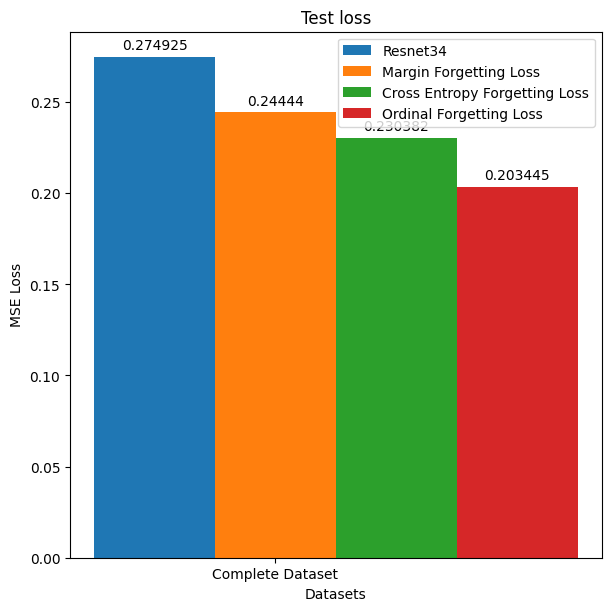

In [26]:
datasets = ['Complete Dataset']

test_losses = {
    "Resnet34": [test_loss_cnn],
    "Margin Forgetting Loss": [test_loss_mar], 
    "Cross Entropy Forgetting Loss": [test_loss_ce],
    "Ordinal Forgetting Loss": [test_loss_ord]
}

bar_plot(datasets, test_losses, "Datasets", "MSE Loss", "Test loss", 'test_losses')

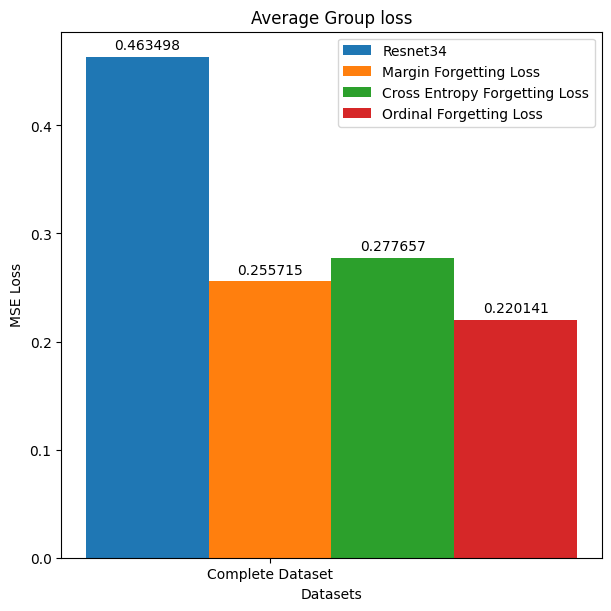

In [27]:
datasets = ['Complete Dataset']

test_losses = {
    "Resnet34": [group_tst_loss_cnn],
    "Margin Forgetting Loss": [group_tst_loss_mar], 
    "Cross Entropy Forgetting Loss": [group_loss_ce],
    "Ordinal Forgetting Loss": [group_loss_ord]
}

bar_plot(datasets, test_losses, "Datasets", "MSE Loss", "Average Group loss", 'grp_test_losses')

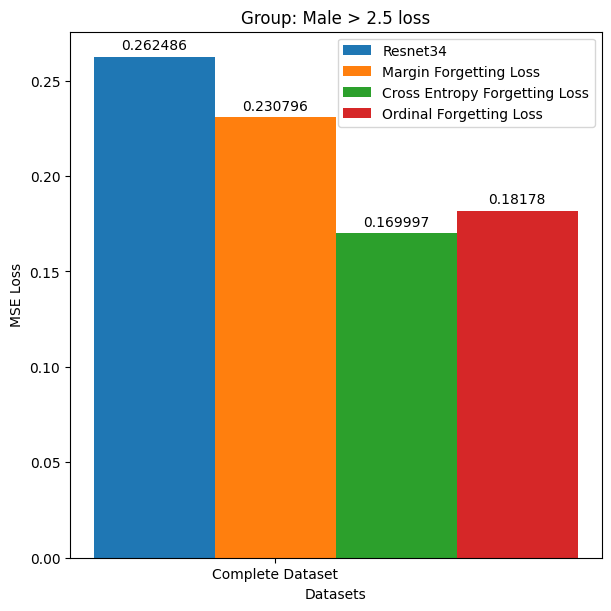

In [28]:
datasets = ['Complete Dataset']

test_losses = {
    "Resnet34": [groups_cnn['m b']],
    "Margin Forgetting Loss": [groups_fs_mar['m b']], 
    "Cross Entropy Forgetting Loss": [groups_ce['m b']],
    "Ordinal Forgetting Loss": [groups_ord['m b']]
}

bar_plot(datasets, test_losses, "Datasets", "MSE Loss", "Group: Male > 2.5 loss", 'test_losses')

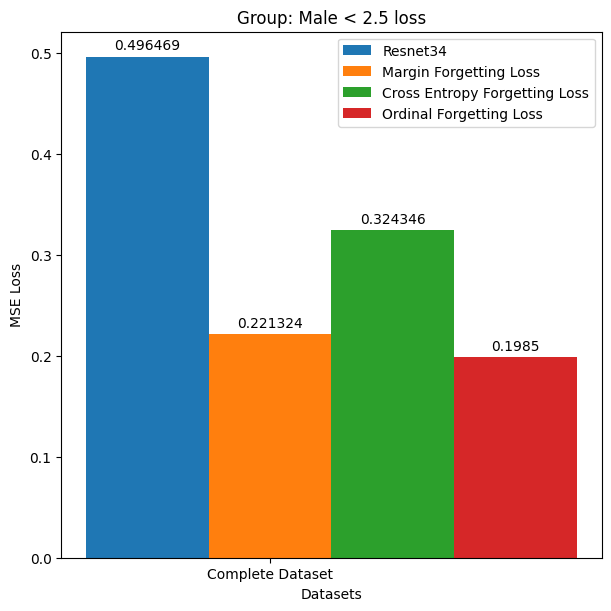

In [29]:
datasets = ['Complete Dataset']

test_losses = {
    "Resnet34": [groups_cnn['m u']],
    "Margin Forgetting Loss": [groups_fs_mar['m u']], 
    "Cross Entropy Forgetting Loss": [groups_ce['m u']],
    "Ordinal Forgetting Loss": [groups_ord['m u']]
}

bar_plot(datasets, test_losses, "Datasets", "MSE Loss", "Group: Male < 2.5 loss", 'test_losses')

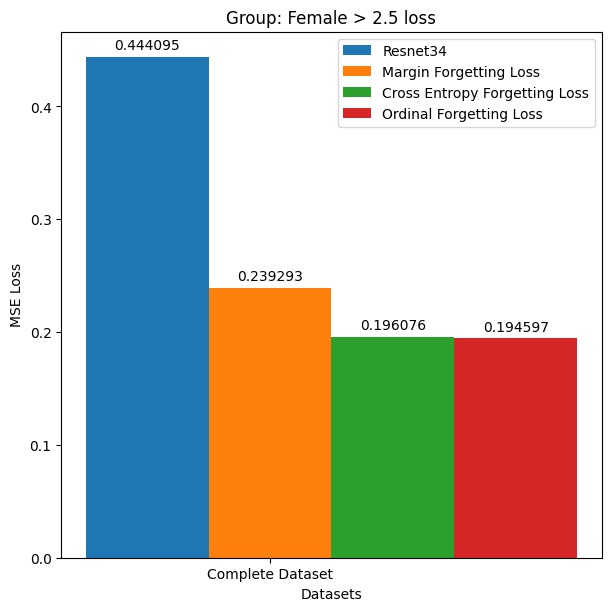

In [30]:
datasets = ['Complete Dataset']

test_losses = {
    "Resnet34": [groups_cnn['f b']],
    "Margin Forgetting Loss": [groups_fs_mar['f b']], 
    "Cross Entropy Forgetting Loss": [groups_ce['f b']],
    "Ordinal Forgetting Loss": [groups_ord['f b']]
}

bar_plot(datasets, test_losses, "Datasets", "MSE Loss", "Group: Female > 2.5 loss", 'test_losses')

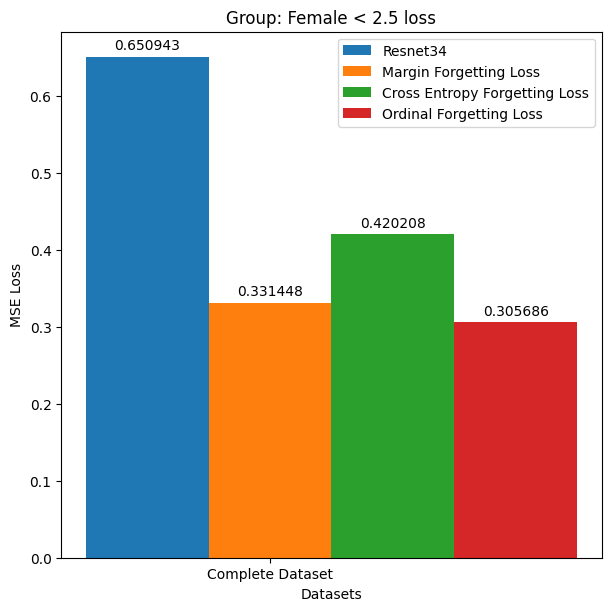

In [31]:
datasets = ['Complete Dataset']

test_losses = {
    "Resnet34": [groups_cnn['f u']],
    "Margin Forgetting Loss": [groups_fs_mar['f u']], 
    "Cross Entropy Forgetting Loss": [groups_ce['f u']],
    "Ordinal Forgetting Loss": [groups_ord['f u']]
}

bar_plot(datasets, test_losses, "Datasets", "MSE Loss", "Group: Female < 2.5 loss", 'test_losses')